In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
from transformers import pipeline
import re
import string
from scipy.stats import randint, uniform
from langdetect import detect
from sklearn.ensemble import IsolationForest
from wordcloud import WordCloud
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay



/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Importation des **données**

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/WELFake_Dataset.csv')


In [ ]:
data.shape

(72134, 4)

In [ ]:
data.columns


Index(['title', 'text', 'label'], dtype='object')

In [ ]:
data = data.drop(columns=['Unnamed: 0'])


In [ ]:
data.head()


,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [ ]:
data.dtypes


,0
title,object
text,object
label,int64


In [ ]:
data.isnull().sum()


,0
title,558
text,39
label,0


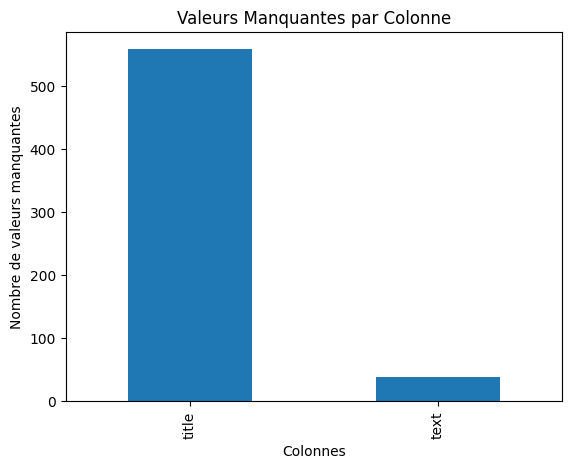

In [ ]:
missing_data = data.isnull().sum()
missing_data = missing_data[missing_data > 0]

missing_data.plot(kind='bar')
plt.title('Valeurs Manquantes par Colonne')
plt.ylabel('Nombre de valeurs manquantes')
plt.xlabel('Colonnes')
plt.show()

Filtrage des lignes avec des textes non nuls

In [ ]:
filtered_data = []
for index, row in data.iterrows():
    if pd.notnull(row['text']):
        filtered_data.append(row)

data = pd.DataFrame(filtered_data)

In [ ]:
data.isnull().sum()


,0
title,558
text,0
label,0


Génération de titres pour les lignes avec des titres manquants

In [ ]:
def generate_title_from_text(text):
    try:
        # Générer un résumé court pour le titre
        summary = summarizer(text, max_length=10, min_length=5, do_sample=False)
        return summary[0]['summary_text']
    except Exception as e:
        return "Titre non généré"

In [ ]:
missing_titles = data['title'].isnull()

data.loc[missing_titles, 'title'] = data.loc[missing_titles, 'text'].apply(generate_title_from_text)

In [ ]:
data.isnull().sum()


,0
title,0
text,0
label,0


In [ ]:
data.duplicated().sum()


8456

In [ ]:
data = data.drop_duplicates()


In [ ]:
data.duplicated().sum()


0

In [1]:
!pip install langdetect



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=2f10ebba24ff75ff9eacfe2d21641859d89298c23cae3401bc7cc2f9454c984f
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


Détection et comptage des **langues** des textes

Répéter ce code jusqu'à ne garder que la langue anglaise





In [ ]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return "error"

data['language'] = data['text'].apply(detect_language)

language_counts = data['language'].value_counts()
language_counts

,count
language,
en,62498


Filtrer les articles en **anglais**

In [ ]:
data = data[data['language'] == 'en']

data.shape

(62498, 4)

In [ ]:
data = data.drop(columns=['language'])


In [ ]:
data.columns

Index(['title', 'text', 'label'], dtype='object')

Calcul de la **longueur** des textes

In [ ]:
data['text_length'] = data['text'].apply(len)


In [ ]:

data[['text', 'text_length']].head()

,text,text_length
0,No comment is expected from Barack Obama Membe...,5049
1,Did they post their votes for Hillary already?,46
2,"Now, most of the demonstrators gathered last ...",216
3,A dozen politically active pastors came here f...,8010
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1916


In [ ]:
data['text_length'].describe()


,text_length
count,62498.000000
mean,3313.055602
std,3602.477693
min,4.000000
25%,1472.000000
50%,2477.000000
75%,4127.000000
max,134206.000000


# Détection et suppression des **outliers** basée sur la longueur des textes.

Répéter jusqu'à obtenir une bonne description

In [ ]:


model = IsolationForest(contamination=0.05, random_state=42)
data['outliers'] = model.fit_predict(data[['text_length']])
data['outliers'] = data['outliers'].map({1: 0, -1: 1})
num_outliers = data['outliers'].sum()
print(f"Nombre d'outliers détectés : {num_outliers}")

outliers = data[data['outliers'] == 1]
outliers.head()

data_clean = data[data['outliers'] == 0].reset_index(drop=True)

print(f"Shape après suppression des outliers: {data_clean.shape}")

Nombre d'outliers détectés : 2538
Shape après suppression des outliers: (48386, 5)


In [ ]:
data = data_clean


In [ ]:
data['text_length'].describe()

,text_length
count,48386.000000
mean,2319.350845
std,1185.127887
min,379.000000
25%,1432.000000
50%,2238.000000
75%,3077.000000
max,5089.000000


In [ ]:
data = data_clean[['title', 'text', 'label']]


In [ ]:
data.columns

Index(['title', 'text', 'label'], dtype='object')

In [ ]:
data['label'].value_counts()

,count
label,
0,26069
1,22317


# Choix entre Suréchantillonnage et Sous-échantillonnage des Données

Suréchantillonnage des données

In [ ]:
X = data[['title', 'text']]
y = data['label']

oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_oversampled, y_oversampled = oversampler.fit_resample(X, y)

data_oversampled = pd.concat([X_oversampled, y_oversampled], axis=1)

data_oversampled['label'].value_counts()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


,count
label,
1,26069
0,26069


Sous-échantillonnage des données

In [ ]:
X = data[['title', 'text']]
y = data['label']
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_undersampled, y_undersampled = undersampler.fit_resample(X, y)

data_undersampled = pd.concat([X_undersampled, y_undersampled], axis=1)
data_undersampled['label'].value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


,count
label,
0,22317
1,22317


Régression logistique sur **données** **suréchantillonnées**




In [ ]:
X_oversampled = data_oversampled[['title', 'text']]
y_oversampled = data_oversampled['label']

vectorizer = TfidfVectorizer(stop_words='english')

X_oversampled_tfidf = vectorizer.fit_transform(X_oversampled['title'] + " " + X_oversampled['text'])
X_train, X_test, y_train, y_test = train_test_split(X_oversampled_tfidf, y_oversampled, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9477

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      5199
           1       0.94      0.95      0.95      5229

    accuracy                           0.95     10428
   macro avg       0.95      0.95      0.95     10428
weighted avg       0.95      0.95      0.95     10428



Régression logistique sur **données sous-échantillonnées**

In [ ]:
X_under_sampled = data_undersampled[['title', 'text']]
y_under_sampled = data_undersampled['label']

vectorizer = TfidfVectorizer(stop_words='english')
X_under_sampled_tfidf = vectorizer.fit_transform(X_under_sampled['title'] + " " + X_under_sampled['text'])

X_train, X_test, y_train, y_test = train_test_split(X_under_sampled_tfidf, y_under_sampled, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9424

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      4504
           1       0.94      0.95      0.94      4423

    accuracy                           0.94      8927
   macro avg       0.94      0.94      0.94      8927
weighted avg       0.94      0.94      0.94      8927



Application de la méthode d'échantillonnage **optimale**

In [ ]:
data = data_oversampled.copy()

data.shape
data.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
2,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1
3,Sports Bar Owner Bans NFL Games…Will Show Only...,"The owner of the Ringling Bar, located south o...",1
4,Latest Pipeline Leak Underscores Dangers Of Da...,"FILE – In this Sept. 15, 2005 file photo, the ...",1


In [ ]:
data['label'].value_counts()

,count
label,
1,26069
0,26069


# Nettoyage de données

Suppression des espaces **inutiles**

In [ ]:
def remove_extra_spaces(text):
    text = text.strip()
    text = ' '.join(text.split())
    return text

data['text'] = data['text'].apply(remove_extra_spaces)


Suppression des **caractères spéciaux**

In [ ]:
def remove_special_characters(text):
    # Supprimer les liens (URLs)
    text = re.sub(r'http\S+', '', text)
    # Supprimer les mentions (@utilisateur)
    text = re.sub(r'@\w+', '', text)
    # Supprimer les hashtags (#hashtag)
    text = re.sub(r'#\w+', '', text)
    # Supprimer les chiffres
    text = re.sub(r'\d+', '', text)
    # Supprimer la ponctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text

data['text'] = data['text'].apply(remove_special_characters)

Conversion du texte en **minuscules**

In [ ]:
def convert_to_lowercase(text):
    return text.lower()

data['text'] = data['text'].apply(convert_to_lowercase)

Suppression des mots **vides**

In [ ]:
stopwords = ['the', 'and', 'is', 'in', 'it', 'on', 'to', 'of', 'a', 'for', 'with', 'as', 'that']

def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word not in stopwords]
    return ' '.join(words)

data['text'] = data['text'].apply(remove_stopwords)

Suppression des caractères non alphabétiques

In [ ]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

data['text'] = data['text'].apply(clean_text)


Suppression de la **ponctuation**

In [ ]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

data['text'] = data['text'].apply(remove_punctuation)
data['title'] = data['title'].apply(remove_punctuation)

# Nuages de mots pour **fake** et **real** news

In [ ]:
text_fake = ' '.join(data.loc[data['label'] == 0, 'title'])
text_real = ' '.join(data.loc[data['label'] == 1, 'title'])

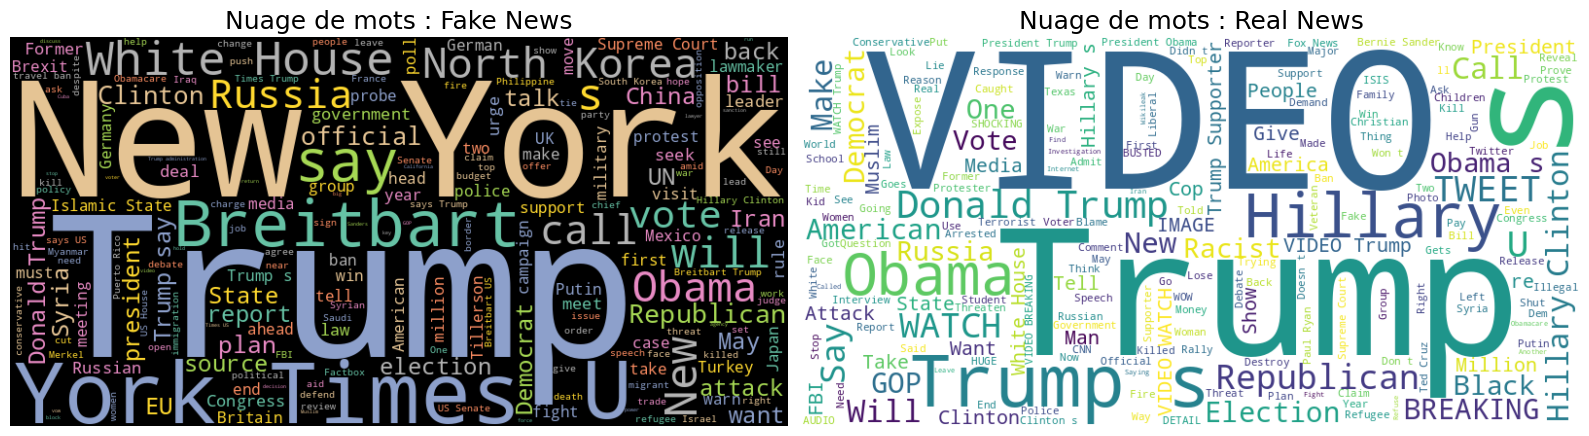

In [ ]:
wordcloud_fake = WordCloud(width=800, height=400, background_color='black', colormap='Set2').generate(text_fake)
wordcloud_real = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_real)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Fake news
ax1.imshow(wordcloud_fake, interpolation='bilinear')
ax1.axis('off')
ax1.set_title("Nuage de mots : Fake News", fontsize=18)

# Real news
ax2.imshow(wordcloud_real, interpolation='bilinear')
ax2.axis('off')
ax2.set_title("Nuage de mots : Real News", fontsize=18)

plt.tight_layout()
plt.show()

# Enregistrement du dataset nettoyé, prêt et final

In [ ]:
data.to_csv('my_dataset.csv', index=False)




---



In [ ]:
data=pd.read_csv('/content/drive/MyDrive/my_dataset.csv')

# Vectorisation des données avec TF-IDF

Fusion des **colonnes** pour **TF-IDF**

In [ ]:
data['combined'] = data['title'] + " " + data['text']

Initialisation du **TF-IDF**

In [ ]:
tfidf = TfidfVectorizer(stop_words='english',max_features=100000)

Application du **TF-IDF**

In [ ]:
tfidf_matrix = tfidf.fit_transform(data['combined'])

In [ ]:
tfidf_matrix.shape

(55790, 100000)

In [ ]:
import joblib
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
print("TF-IDF vectorizer sauvegardé.")

TF-IDF vectorizer sauvegardé.


# Division des données en train et test

In [ ]:
X = tfidf_matrix
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Modèles sans Hyperparamètres

## Régression logistique

In [ ]:
model = LogisticRegression()

In [ ]:
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9550
Precision: 0.9472
Recall: 0.9638
F1 Score: 0.9554


In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      5579
           1       0.95      0.96      0.96      5579

    accuracy                           0.96     11158
   macro avg       0.96      0.96      0.96     11158
weighted avg       0.96      0.96      0.96     11158



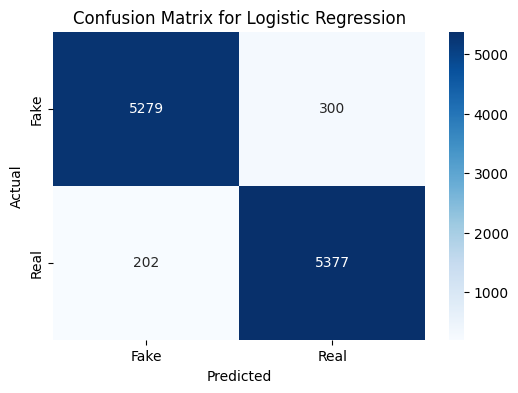

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Support Vector Classification

In [ ]:
model_svm = SVC()

In [ ]:
model_svm.fit(X_train, y_train)

SVC()

In [ ]:
y_pred_svm = model_svm.predict(X_test)

In [ ]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print(f"SVM Accuracy: {accuracy_svm:.4f}")
print(f"SVM Precision: {precision_svm:.4f}")
print(f"SVM Recall: {recall_svm:.4f}")
print(f"SVM F1 Score: {f1_svm:.4f}")

SVM Accuracy: 0.9667
SVM Precision: 0.9614
SVM Recall: 0.9724
SVM F1 Score: 0.9669


In [ ]:
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      5579
           1       0.96      0.97      0.97      5579

    accuracy                           0.97     11158
   macro avg       0.97      0.97      0.97     11158
weighted avg       0.97      0.97      0.97     11158



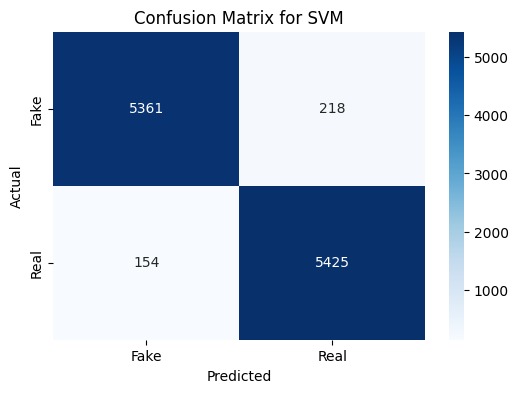

In [ ]:
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Confusion Matrix for SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Random Forest

In [ ]:
model_rf = RandomForestClassifier()

In [ ]:
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred_rf = model_rf.predict(X_test)

In [ ]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print(f"Random Forest Precision: {precision_rf:.4f}")
print(f"Random Forest Recall: {recall_rf:.4f}")
print(f"Random Forest F1 Score: {f1_rf:.4f}")

Random Forest Accuracy: 0.9401
Random Forest Precision: 0.9307
Random Forest Recall: 0.9511
Random Forest F1 Score: 0.9408


In [ ]:
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      5579
           1       0.93      0.95      0.94      5579

    accuracy                           0.94     11158
   macro avg       0.94      0.94      0.94     11158
weighted avg       0.94      0.94      0.94     11158



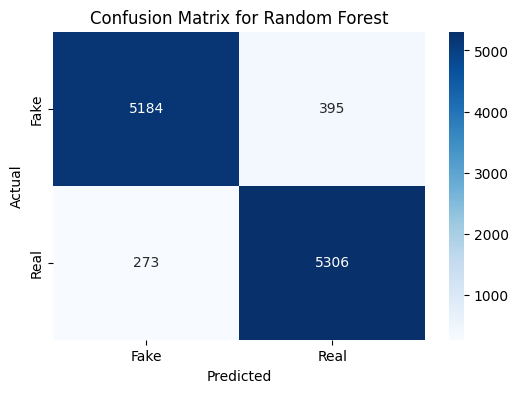

In [ ]:
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## XGBoost Classifier

In [ ]:
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [ ]:
model_xgb.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:20:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred_xgb = model_xgb.predict(X_test)

In [ ]:
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")
print(f"XGBoost Precision: {precision_xgb:.4f}")
print(f"XGBoost Recall: {recall_xgb:.4f}")
print(f"XGBoost F1 Score: {f1_xgb:.4f}")

XGBoost Accuracy: 0.9711
XGBoost Precision: 0.9632
XGBoost Recall: 0.9797
XGBoost F1 Score: 0.9714


In [ ]:
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      5579
           1       0.96      0.98      0.97      5579

    accuracy                           0.97     11158
   macro avg       0.97      0.97      0.97     11158
weighted avg       0.97      0.97      0.97     11158



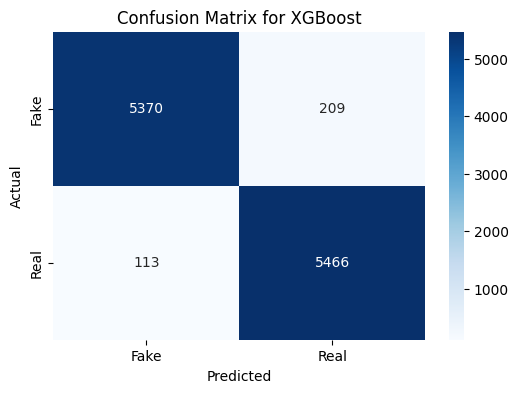

In [ ]:
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Confusion Matrix for XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## LightGBM Classifier

In [ ]:
model_lgb = lgb.LGBMClassifier()

In [ ]:
model_lgb.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 22316, number of negative: 22316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 14.512584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1259585
[LightGBM] [Info] Number of data points in the train set: 44632, number of used features: 21320
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMClassifier()

In [ ]:
y_pred_lgb = model_lgb.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
precision_lgb = precision_score(y_test, y_pred_lgb)
recall_lgb = recall_score(y_test, y_pred_lgb)
f1_lgb = f1_score(y_test, y_pred_lgb)

print(f"LightGBM Accuracy: {accuracy_lgb:.4f}")
print(f"LightGBM Precision: {precision_lgb:.4f}")
print(f"LightGBM Recall: {recall_lgb:.4f}")
print(f"LightGBM F1 Score: {f1_lgb:.4f}")

LightGBM Accuracy: 0.9722
LightGBM Precision: 0.9654
LightGBM Recall: 0.9796
LightGBM F1 Score: 0.9724


In [ ]:
print("\nLightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgb))


LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      5579
           1       0.97      0.98      0.97      5579

    accuracy                           0.97     11158
   macro avg       0.97      0.97      0.97     11158
weighted avg       0.97      0.97      0.97     11158



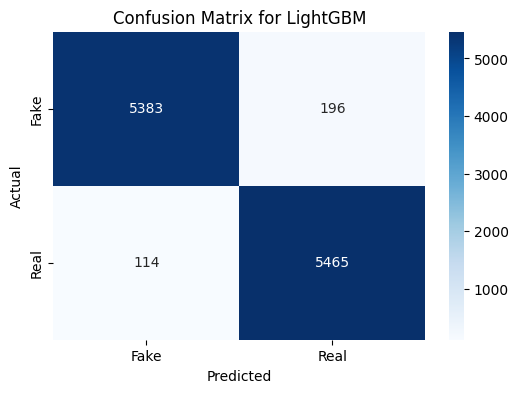

In [ ]:
conf_matrix_lgb = confusion_matrix(y_test, y_pred_lgb)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lgb, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Confusion Matrix for LightGBM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Naive Bayes multinomial

In [ ]:
model_nb = MultinomialNB()

In [ ]:
model_nb.fit(X_train, y_train)

MultinomialNB()

In [ ]:
y_pred_nb = model_nb.predict(X_test)

In [ ]:
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)

print(f"Naive Bayes Accuracy: {accuracy_nb:.4f}")
print(f"Naive Bayes Precision: {precision_nb:.4f}")
print(f"Naive Bayes Recall: {recall_nb:.4f}")
print(f"Naive Bayes F1 Score: {f1_nb:.4f}")


Naive Bayes Accuracy: 0.8690
Naive Bayes Precision: 0.8603
Naive Bayes Recall: 0.8810
Naive Bayes F1 Score: 0.8705


In [ ]:
print("\nNaive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      5579
           1       0.86      0.88      0.87      5579

    accuracy                           0.87     11158
   macro avg       0.87      0.87      0.87     11158
weighted avg       0.87      0.87      0.87     11158



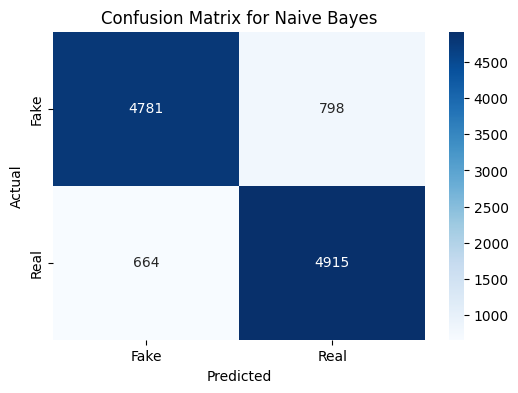

In [ ]:
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Confusion Matrix for Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## K-Nearest Neighbors

In [ ]:
model_knn = KNeighborsClassifier()


In [ ]:
model_knn.fit(X_train, y_train)


KNeighborsClassifier()

In [ ]:
y_pred_knn = model_knn.predict(X_test)


In [ ]:
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

print(f"KNN Accuracy: {accuracy_knn:.4f}")
print(f"KNN Precision: {precision_knn:.4f}")
print(f"KNN Recall: {recall_knn:.4f}")
print(f"KNN F1 Score: {f1_knn:.4f}")

KNN Accuracy: 0.8270
KNN Precision: 0.8585
KNN Recall: 0.7831
KNN F1 Score: 0.8191


In [ ]:
print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn))


KNN Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      5579
           1       0.86      0.78      0.82      5579

    accuracy                           0.83     11158
   macro avg       0.83      0.83      0.83     11158
weighted avg       0.83      0.83      0.83     11158



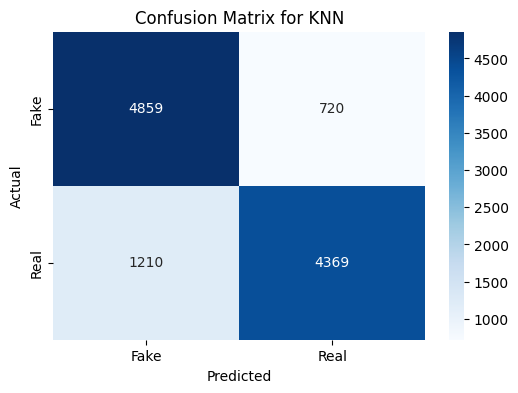

In [ ]:
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Confusion Matrix for KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Multi-layer Perceptron Classifier

In [ ]:
mlp_model = MLPClassifier(max_iter=1000, random_state=42)


In [ ]:
mlp_model.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(max_iter=1000, random_state=42)

In [ ]:
y_pred_mlp = mlp_model.predict(X_test)


In [ ]:
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)

print(f"MLP Accuracy: {accuracy_mlp:.4f}")
print(f"MLP Precision: {precision_mlp:.4f}")
print(f"MLP Recall: {recall_mlp:.4f}")
print(f"MLP F1 Score: {f1_mlp:.4f}")

MLP Accuracy: 0.9704
MLP Precision: 0.9691
MLP Recall: 0.9719
MLP F1 Score: 0.9705


In [ ]:
print("\nMLP Classification Report:")
print(classification_report(y_test, y_pred_mlp))


MLP Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5579
           1       0.97      0.97      0.97      5579

    accuracy                           0.97     11158
   macro avg       0.97      0.97      0.97     11158
weighted avg       0.97      0.97      0.97     11158



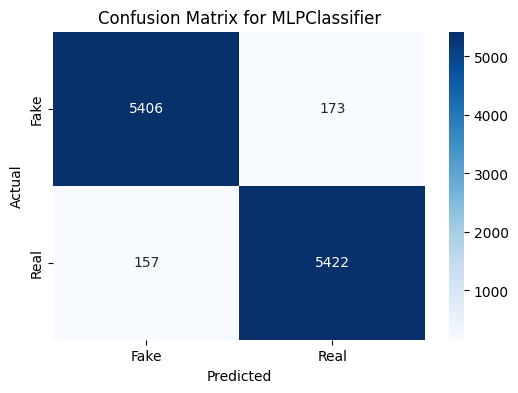

In [ ]:
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Confusion Matrix for MLPClassifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

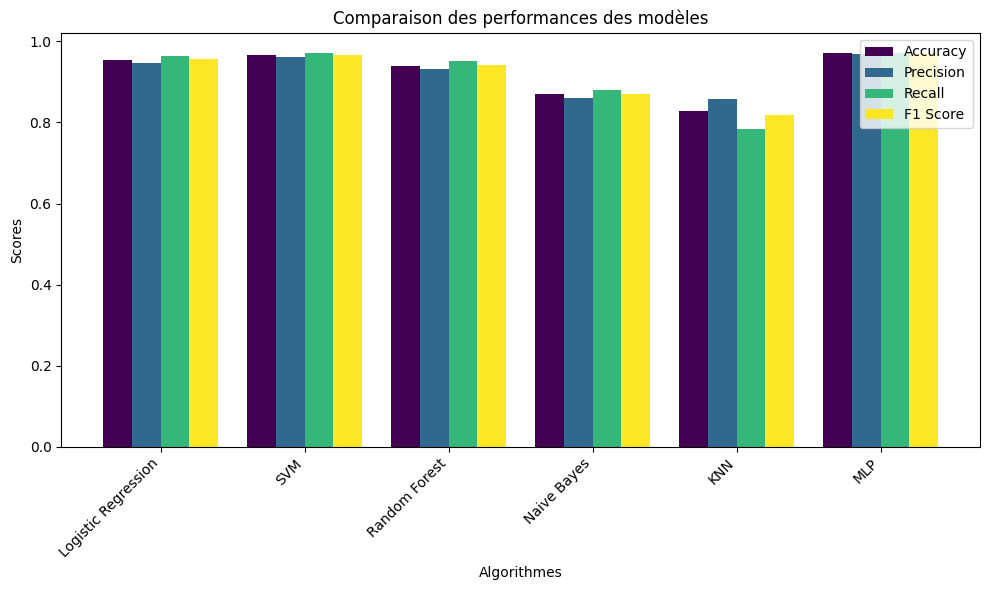

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Données des performances des modèles
models = ['Logistic Regression', 'SVM', 'Random Forest', 'Naive Bayes', 'KNN', 'MLP']
accuracy = [0.9550, 0.9667, 0.9401, 0.8690, 0.8270, 0.9704]
precision = [0.9472, 0.9614, 0.9307, 0.8603, 0.8585, 0.9691]
recall = [0.9638, 0.9724, 0.9511, 0.8810, 0.7831, 0.9719]
f1_score = [0.9554, 0.9669, 0.9408, 0.8705, 0.8191, 0.9705]

# Position des barres sur l'axe des X
x = np.arange(len(models))

# Largeur des barres
width = 0.2

# Obtenir la palette de couleurs 'viridis'
viridis = plt.cm.viridis(np.linspace(0, 1, 4))

# Créer les sous-graphes
fig, ax = plt.subplots(figsize=(10, 6))

# Afficher les barres pour chaque métrique avec les couleurs viridis
bar1 = ax.bar(x - width*1.5, accuracy, width, label='Accuracy', color=viridis[0])
bar2 = ax.bar(x - width/2, precision, width, label='Precision', color=viridis[1])
bar3 = ax.bar(x + width/2, recall, width, label='Recall', color=viridis[2])
bar4 = ax.bar(x + width*1.5, f1_score, width, label='F1 Score', color=viridis[3])

# Ajouter les étiquettes et le titre
ax.set_xlabel('Algorithmes')
ax.set_ylabel('Scores')
ax.set_title('Comparaison des performances des modèles')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

# Afficher les résultats
plt.tight_layout()
plt.show()


<ipython-input-6-87c83642b818>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results, ax=axes[0], palette="viridis")
<ipython-input-6-87c83642b818>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Precision', data=results, ax=axes[1], palette="viridis")
<ipython-input-6-87c83642b818>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Recall', data=results, ax=axes[2], palette="viridis")
<ipython-input-6-87c83642b818>:40: FutureWarning: 

Passing `palette` without assigning `hue` i

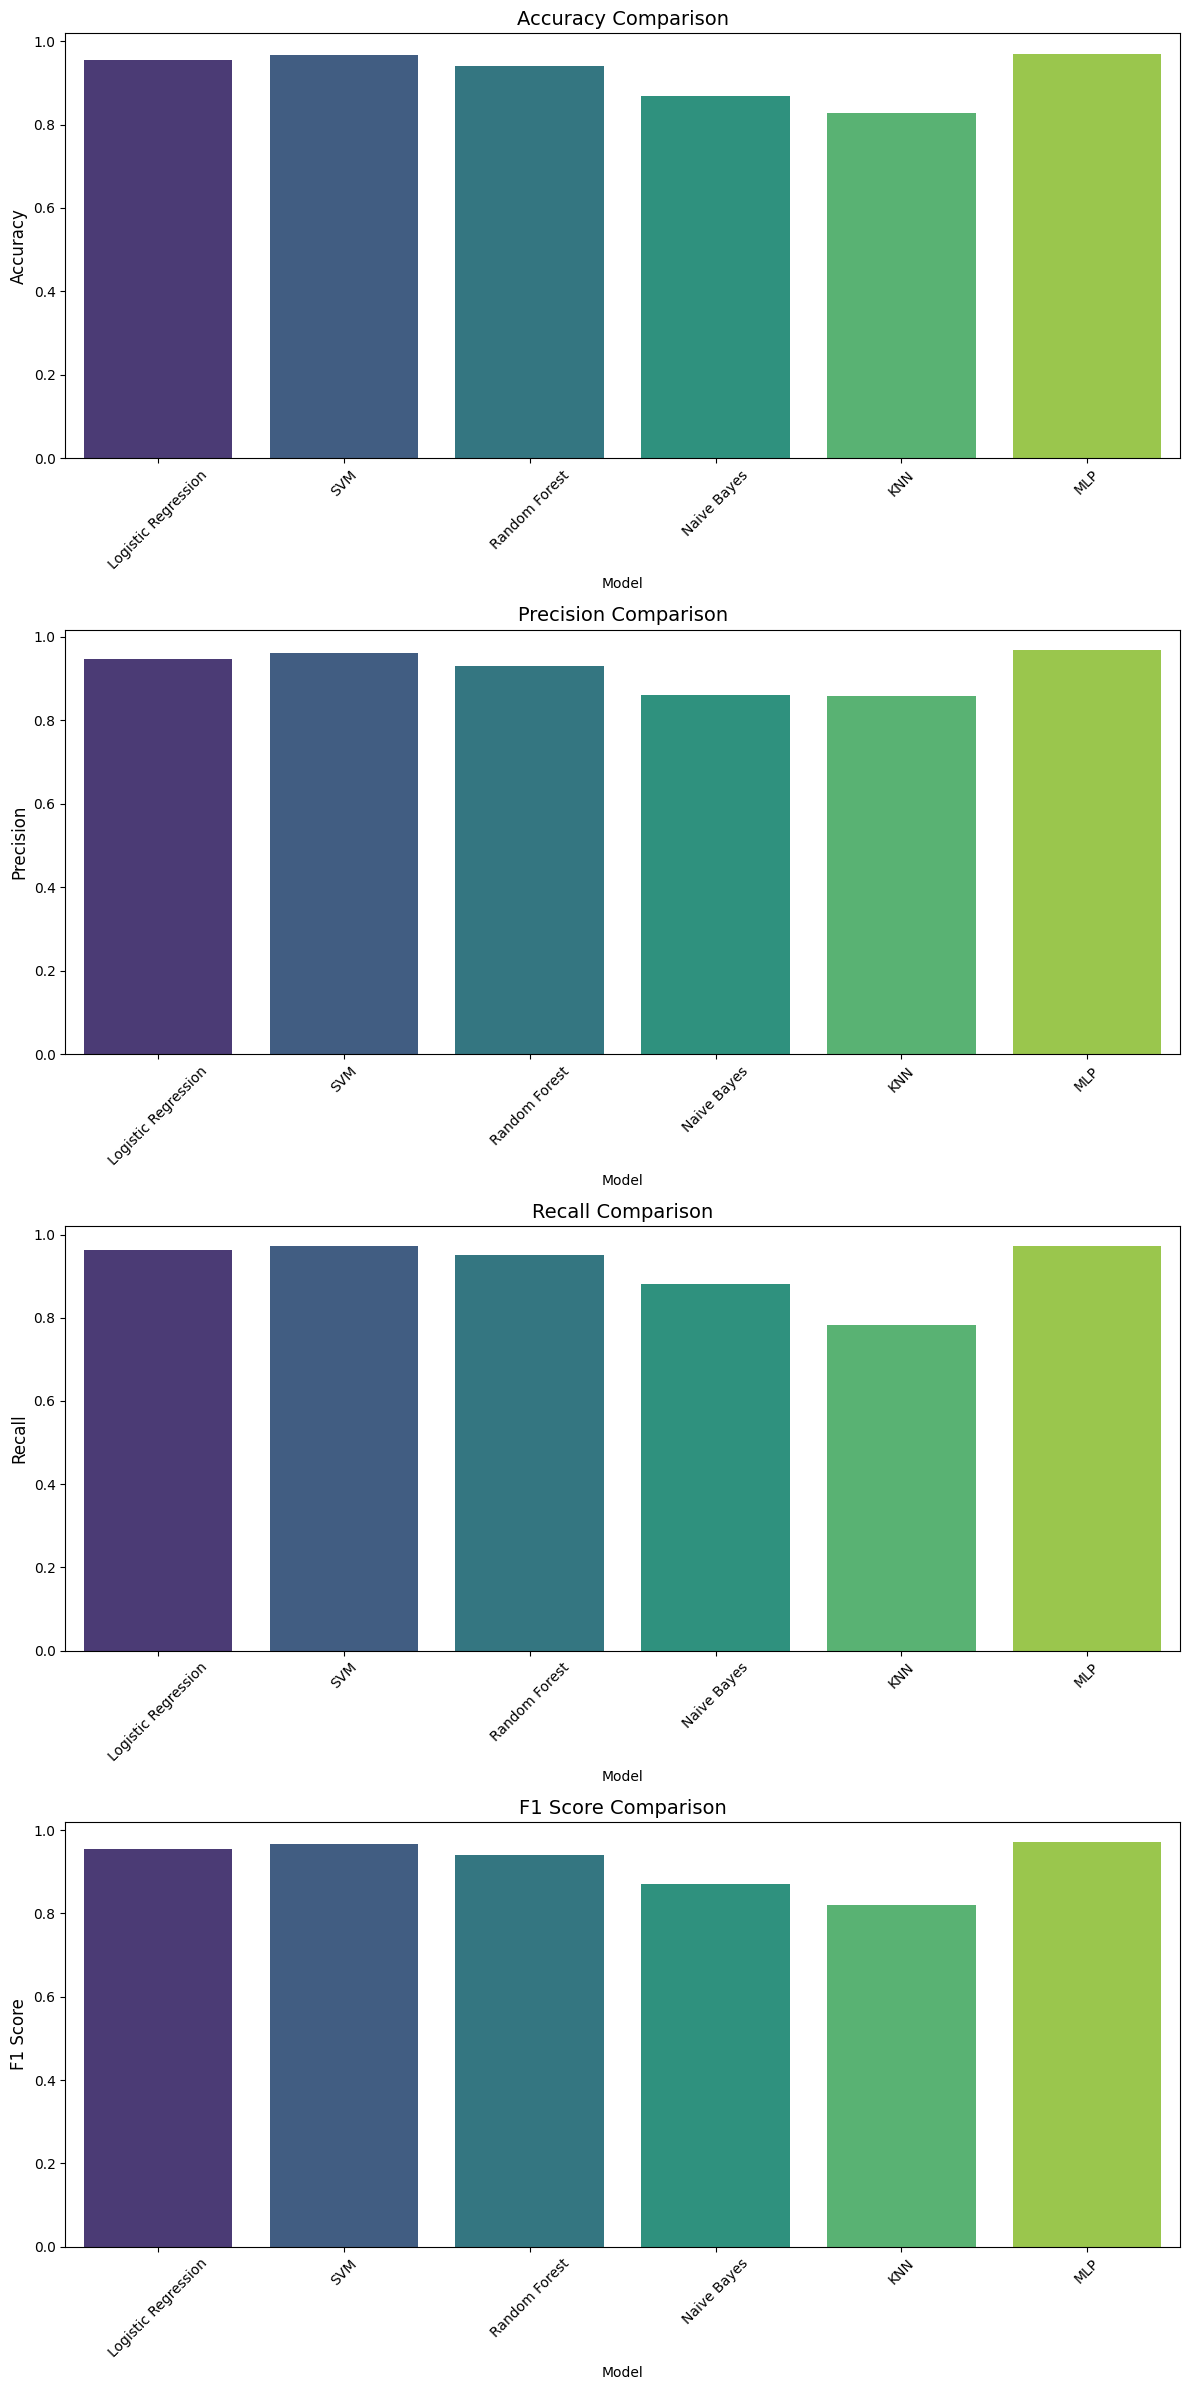

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Données des performances des modèles
models = ['Logistic Regression', 'SVM', 'Random Forest', 'Naive Bayes', 'KNN', 'MLP']
accuracy = [0.9550, 0.9667, 0.9401, 0.8690, 0.8270, 0.9704]
precision = [0.9472, 0.9614, 0.9307, 0.8603, 0.8585, 0.9691]
recall = [0.9638, 0.9724, 0.9511, 0.8810, 0.7831, 0.9719]
f1_score = [0.9554, 0.9669, 0.9408, 0.8705, 0.8191, 0.9705]

# Créer un DataFrame à partir des données
results = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score
})

# Créer la figure avec 4 sous-graphiques
fig, axes = plt.subplots(4, 1, figsize=(12, 24))  # 4 lignes, 1 colonne

# Afficher les barres pour chaque métrique avec la palette 'viridis'
sns.barplot(x='Model', y='Accuracy', data=results, ax=axes[0], palette="viridis")
axes[0].set_title('Accuracy Comparison', fontsize=14)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(x='Model', y='Precision', data=results, ax=axes[1], palette="viridis")
axes[1].set_title('Precision Comparison', fontsize=14)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

sns.barplot(x='Model', y='Recall', data=results, ax=axes[2], palette="viridis")
axes[2].set_title('Recall Comparison', fontsize=14)
axes[2].set_ylabel('Recall', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)

sns.barplot(x='Model', y='F1 Score', data=results, ax=axes[3], palette="viridis")
axes[3].set_title('F1 Score Comparison', fontsize=14)
axes[3].set_ylabel('F1 Score', fontsize=12)
axes[3].tick_params(axis='x', rotation=45)

# Ajouter une mise en page serrée pour éviter les chevauchements
plt.tight_layout()

# Afficher les résultats
plt.show()


# Modèles avec Hyperparamètres

## Régression logistique

In [ ]:
logreg = LogisticRegression(solver='liblinear')

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

In [ ]:
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=2)

In [ ]:
grid_search.best_params_

{'C': 10, 'penalty': 'l1', 'solver': 'saga'}

In [ ]:
grid_search.best_score_

0.968744473842543

In [ ]:
y_pred = grid_search.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy : {accuracy:.2f}")
print(f"Precision : {precision:.2f}")
print(f"Recall : {recall:.2f}")
print(f"F1-Score : {f1:.2f}")

print("\nRapport de classification :\n", classification_report(y_test, y_pred))

Accuracy : 0.97
Precision : 0.96
Recall : 0.97
F1-Score : 0.97

Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      5579
           1       0.96      0.97      0.97      5579

    accuracy                           0.97     11158
   macro avg       0.97      0.97      0.97     11158
weighted avg       0.97      0.97      0.97     11158



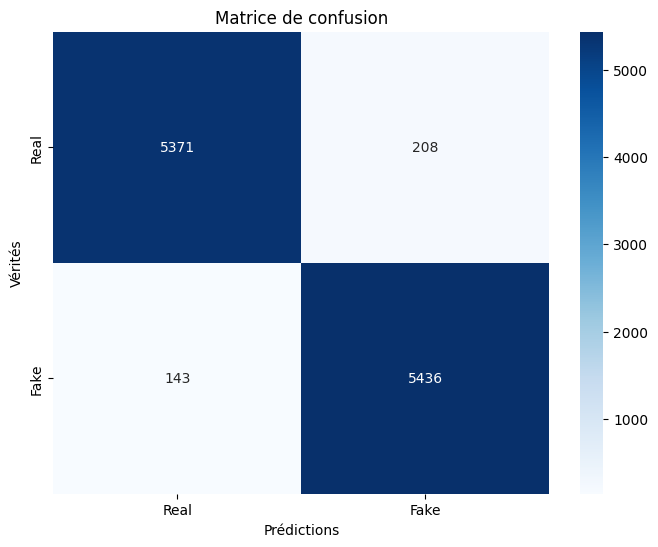

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("Matrice de confusion")
plt.show()

## Support Vector Classification

Optimisation des calculs avec **PCA**

In [ ]:
pca = PCA(n_components=200, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


In [ ]:
param_distributions = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
}

In [ ]:
random_search_svm = RandomizedSearchCV(
    SVC(),
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1
)





In [ ]:
random_search_svm.fit(X_train_pca, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='accuracy', verbose=2)

In [ ]:
random_search_svm.best_params_


{'kernel': 'rbf', 'gamma': 'scale', 'C': 10}

In [ ]:
random_search_svm.best_score_

0.9527244990376179

In [ ]:
y_pred = random_search_svm.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy : {accuracy:.2f}")
print(f"Precision : {precision:.2f}")
print(f"Recall : {recall:.2f}")
print(f"F1-Score : {f1:.2f}")

print("\nRapport de classification :\n", classification_report(y_test, y_pred))

Accuracy : 0.96
Precision : 0.95
Recall : 0.96
F1-Score : 0.96

Rapport de classification :
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      5579
           1       0.95      0.96      0.96      5579

    accuracy                           0.96     11158
   macro avg       0.96      0.96      0.96     11158
weighted avg       0.96      0.96      0.96     11158



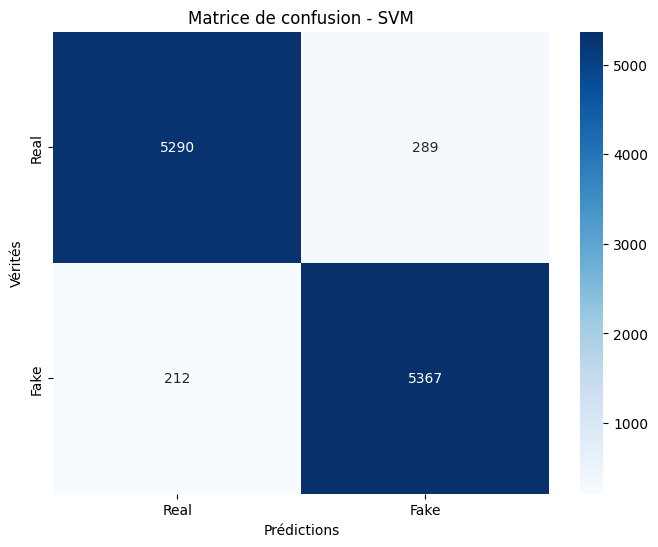

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title('Matrice de confusion - SVM')
plt.show()


## Random Forest

In [ ]:
param_dist_rf = {
    'n_estimators': [100, 200, 500, 1000],  # Nombre d'arbres à tester
    'max_depth': [ 10, 20, 30, 50],  # Profondeur des arbres
    'min_samples_split': [2, 5, 10, 20],  # Nombre minimum d'échantillons pour diviser un noeud
    'min_samples_leaf': [1, 2, 5, 10],  # Nombre minimum d'échantillons pour être une feuille
}


In [ ]:
rf = RandomForestClassifier(random_state=42)


In [ ]:
random_search_rf = RandomizedSearchCV(rf, param_distributions=param_dist_rf,
                                      n_iter=15, cv=3, n_jobs=-1, verbose=3, random_state=0)

In [ ]:
random_search_rf.fit(X_train, y_train)


Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 50],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [100, 200, 500, 1000]},
                   random_state=0, verbose=3)

In [ ]:
random_search_rf.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_depth': 50}

In [ ]:
random_search_rf.best_score_

0.9309463589093183

In [ ]:
y_pred_rf = random_search_rf.best_estimator_.predict(X_test)


In [ ]:
classification_report(y_test, y_pred_rf)

'              precision    recall  f1-score   support\n\n           0       0.94      0.92      0.93      5579\n           1       0.92      0.94      0.93      5579\n\n    accuracy                           0.93     11158\n   macro avg       0.93      0.93      0.93     11158\nweighted avg       0.93      0.93      0.93     11158\n'

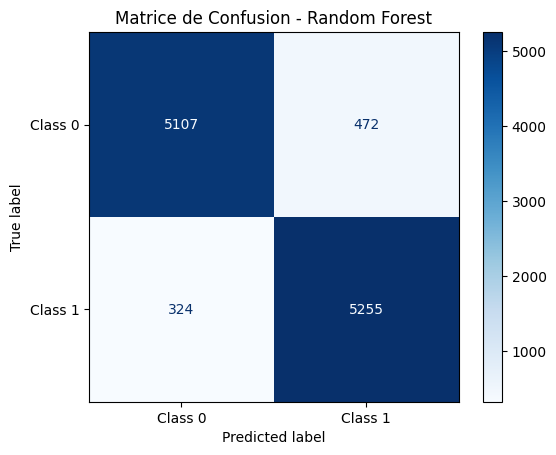

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf)
cmd = ConfusionMatrixDisplay(cm, display_labels=["Class 0", "Class 1"])
cmd.plot(cmap="Blues", values_format="d")

plt.title("Matrice de Confusion - Random Forest")
plt.show()

## XGBoost Classifier

In [ ]:
xgb_model = xgb.XGBClassifier(
    tree_method="hist",  # Méthode de l'arbre pour l'entraînement GPU
    device="cuda",       # Utiliser CUDA pour l'entraînement sur GPU
    use_label_encoder=False,  # Désactiver l'encodeur de label (pour éviter les avertissements)
    eval_metric="logloss"  # Spécifier une métrique d'évaluation
)


In [ ]:
param_dist = {
    "n_estimators": [50, 100, 150, 200],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 6, 9, 12],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2],
    "reg_alpha": [0, 0.01, 0.1],
    "reg_lambda": [0, 0.01, 0.1]
}

In [ ]:
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=80,
    scoring="accuracy",
    cv=5,
    verbose=3,
    n_jobs=-1,
    random_state=42
)

In [ ]:
random_search_xgb.fit(X_train, y_train)


Fitting 5 folds for each of 80 candidates, totalling 400 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:47:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cuda',
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learni...
                                           random_state=None, ...),
                   n_iter=80, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 6, 9, 12],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [50, 100, 150, 200],
                                        'reg_alpha': [0, 0.01, 0.1],
                                        'reg_lambda': [0, 0.01, 0.1],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=3)

In [ ]:
random_search_xgb.best_params_

{'subsample': 1.0,
 'reg_lambda': 0,
 'reg_alpha': 0.01,
 'n_estimators': 150,
 'min_child_weight': 1,
 'max_depth': 6,
 'learning_rate': 0.05,
 'gamma': 0,
 'colsample_bytree': 0.6}

In [ ]:
random_search_xgb.best_score_

0.7916056847784283

In [ ]:
y_pred_xgb = random_search_xgb.best_estimator_.predict(X_test)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:47:50] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [ ]:

accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy : {accuracy:.4f}")

# Calculer la précision, le rappel et le F1-score
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)
print(f"Precision : {precision:.4f}")
print(f"Recall : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")

Accuracy : 0.7217
Precision : 0.7206
Recall : 0.7243
F1-Score : 0.7224


In [ ]:
classification_report(y_test, y_pred_xgb)

'              precision    recall  f1-score   support\n\n           0       0.72      0.72      0.72      5579\n           1       0.72      0.72      0.72      5579\n\n    accuracy                           0.72     11158\n   macro avg       0.72      0.72      0.72     11158\nweighted avg       0.72      0.72      0.72     11158\n'

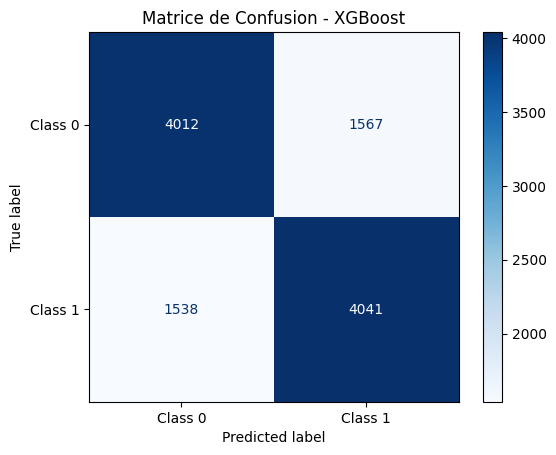

In [ ]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cmd_xgb = ConfusionMatrixDisplay(cm_xgb, display_labels=["Class 0", "Class 1"])
cmd_xgb.plot(cmap="Blues", values_format="d")
plt.title("Matrice de Confusion - XGBoost")
plt.show()

## LightGBM Classifier

In [ ]:
!pip install dask[dataframe]


INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 5.0 MB/s eta 0:00:00


In [ ]:
lgb_model = lgb.LGBMClassifier(random_state=42)


In [ ]:
param_dist = {
    'num_leaves': [31, 50, 100, 200],
    'max_depth': [-1, 5, 10, 15],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0]
}


In [ ]:
random_search_lgb = RandomizedSearchCV(lgb_model, param_distributions=param_dist,
                                       n_iter=10, scoring='accuracy',
                                       cv=3, verbose=1, random_state=42,
                                       n_jobs=-1)

In [ ]:
random_search_lgb.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Number of positive: 22316, number of negative: 22316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 15.324916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1259585
[LightGBM] [Info] Number of data points in the train set: 44632, number of used features: 21320
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             1.0],
                                        'learning_rate': [0.05, 0.1, 0.15],
                                        'max_depth': [-1, 5, 10, 15],
                                        'n_estimators': [50, 100, 200, 300],
                                        'num_leaves': [31, 50, 100, 200],
                                        'subsample': [0.6, 0.7, 0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
random_search_lgb.best_params_

{'subsample': 0.7,
 'num_leaves': 100,
 'n_estimators': 300,
 'max_depth': 5,
 'learning_rate': 0.15,
 'colsample_bytree': 0.8}

In [ ]:
random_search_lgb.best_score_

0.972418936924278

In [ ]:
y_pred_lgb = random_search_lgb.predict(X_test)


In [ ]:
accuracy = accuracy_score(y_test, y_pred_lgb)
precision_recall_f1 = classification_report(y_test, y_pred_lgb)

In [ ]:
print(f"Accuracy : {accuracy}")
print(precision_recall_f1)

Accuracy : 0.9733823265818247
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      5579
           1       0.96      0.98      0.97      5579

    accuracy                           0.97     11158
   macro avg       0.97      0.97      0.97     11158
weighted avg       0.97      0.97      0.97     11158



In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_lgb)
print("Matrice de confusion :")
print(conf_matrix)

Matrice de confusion :
[[5380  199]
 [  98 5481]]


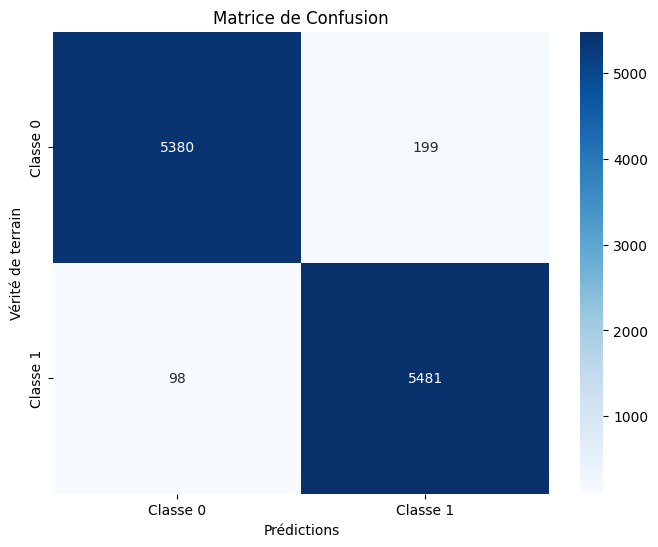

In [ ]:
cm = confusion_matrix(y_test, y_pred_lgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérité de terrain")

plt.show()

## Naive Bayes multinomial

In [ ]:
param_grid = {
    'alpha':  np.linspace(4.2e-6, 4.3e-6, num=1000)
}


In [ ]:
nb_model = MultinomialNB()


In [ ]:
grid_search_nb = GridSearchCV(nb_model, param_grid, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)


In [ ]:
grid_search_nb.fit(X_train, y_train)


Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


GridSearchCV(cv=10, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': array([4.20000000e-06, 4.20010010e-06, 4.20020020e-06, 4.20030030e-06,
       4.20040040e-06, 4.20050050e-06, 4.20060060e-06, 4.20070070e-06,
       4.20080080e-06, 4.20090090e-06, 4.20100100e-06, 4.20110110e-06,
       4.20120120e-06, 4.20130130e-06, 4.20140140e-06, 4.20150150e-06,
       4.20160160e-06, 4.20170170e-0...
       4.29769770e-06, 4.29779780e-06, 4.29789790e-06, 4.29799800e-06,
       4.29809810e-06, 4.29819820e-06, 4.29829830e-06, 4.29839840e-06,
       4.29849850e-06, 4.29859860e-06, 4.29869870e-06, 4.29879880e-06,
       4.29889890e-06, 4.29899900e-06, 4.29909910e-06, 4.29919920e-06,
       4.29929930e-06, 4.29939940e-06, 4.29949950e-06, 4.29959960e-06,
       4.29969970e-06, 4.29979980e-06, 4.29989990e-06, 4.30000000e-06])},
             scoring='accuracy', verbose=1)

In [ ]:
grid_search_nb.best_params_

{'alpha': 4.275875875875876e-06}

In [ ]:
grid_search_nb.best_score_

0.9056507428261205

In [ ]:
best_nb_model = grid_search_nb.best_estimator_


In [ ]:
y_pred_nb_best = best_nb_model.predict(X_test)


In [ ]:

print(f"Accuracy : {accuracy_score(y_test, y_pred_nb_best)}")
print(f"Precision : {precision_score(y_test, y_pred_nb_best)}")
print(f"Recall : {recall_score(y_test, y_pred_nb_best)}")
print(f"F1-Score : {f1_score(y_test, y_pred_nb_best)}")


Accuracy : 0.9025811077253988
Precision : 0.8769721383014434
Recall : 0.936547768417279
F1-Score : 0.9057813989772038


In [ ]:
 classification_report(y_test, y_pred_nb_best)

'              precision    recall  f1-score   support\n\n           0       0.93      0.87      0.90      5579\n           1       0.88      0.94      0.91      5579\n\n    accuracy                           0.90     11158\n   macro avg       0.90      0.90      0.90     11158\nweighted avg       0.90      0.90      0.90     11158\n'

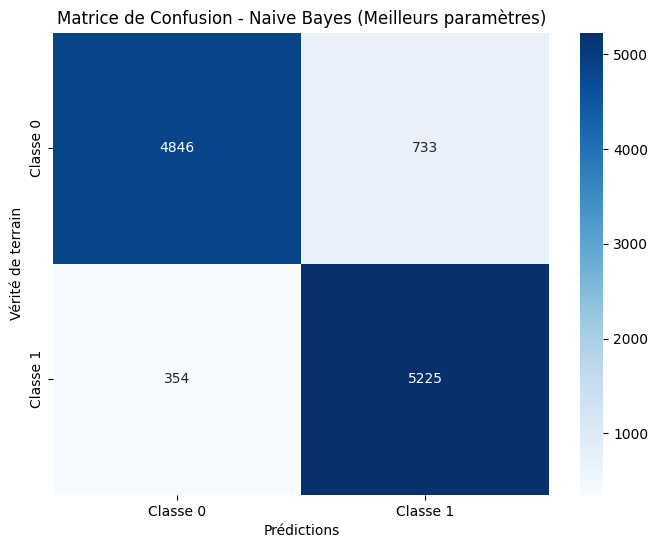

In [ ]:
cm_nb_best = confusion_matrix(y_test, y_pred_nb_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb_best, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.title("Matrice de Confusion - Naive Bayes (Meilleurs paramètres)")
plt.xlabel("Prédictions")
plt.ylabel("Vérité de terrain")
plt.show()

## K-Nearest Neighbors

In [ ]:
pca = PCA(n_components=200, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


In [ ]:
knn = KNeighborsClassifier()


In [ ]:
param_dist = {
    'n_neighbors': np.arange(1, 31, 2),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev', 'cosine'],
    'leaf_size': [10, 20, 30, 40, 50],
}

In [ ]:
random_search_knn = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
)

In [ ]:
random_search_knn.fit(X_train_pca, y_train)


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev',
                                                   'cosine'],
                                        'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]),
                                        'weights': ['uniform', 'distance']},
                   random_state=42, scoring='accuracy')

In [ ]:
random_search_knn.best_params_

{'weights': 'distance', 'n_neighbors': 13, 'metric': 'cosine', 'leaf_size': 10}

In [ ]:
random_search_knn.best_score_

0.87824873677227

In [ ]:
best_knn = random_search_knn.best_estimator_
y_pred = best_knn.predict(X_test_pca)

In [ ]:
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))


Rapport de classification :
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      5579
           1       0.87      0.91      0.89      5579

    accuracy                           0.89     11158
   macro avg       0.89      0.89      0.89     11158
weighted avg       0.89      0.89      0.89     11158



In [ ]:
print("Accuracy :", accuracy_score(y_test, y_pred))


Accuracy : 0.887793511381968


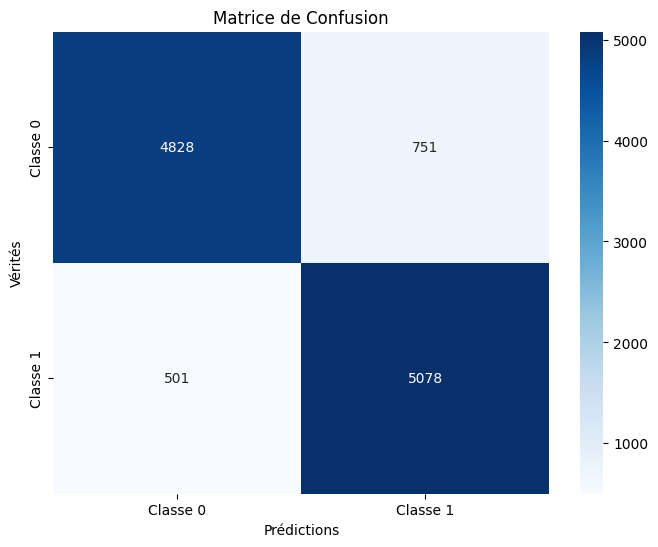

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title('Matrice de Confusion')

plt.show()

## Multi-layer Perceptron Classifier

In [ ]:
pca = PCA(n_components=300, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


Normalisation des données avec StandardScaler

In [ ]:
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_pca)
X_test_scaled = scaler.transform(X_test_pca)

In [ ]:
mlp_clf = MLPClassifier(random_state=42, max_iter=500, early_stopping=True)


In [ ]:
param_dist = {
    'hidden_layer_sizes': [(100,), (150,), (200,), (100, 50), (150, 75)],
    'activation': ['relu', 'tanh'],
    'alpha': uniform(1e-6, 1e-4),
    'learning_rate': ['constant', 'adaptive'],
    'solver': ['adam'],
}

In [ ]:
random_search_mlp = RandomizedSearchCV(
    mlp_clf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42,
)


In [ ]:
random_search_mlp.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=MLPClassifier(early_stopping=True, max_iter=500,
                                           random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x798006ef29e0>,
                                        'hidden_layer_sizes': [(100,), (150,),
                                                               (200,),
                                                               (100, 50),
                                                               (150, 75)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'solver': ['adam']},
                   random_state=42, verbose=2)

In [ ]:
random_search_mlp.best_params_

{'activation': 'relu',
 'alpha': 2.1171920233539622e-05,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'adaptive',
 'solver': 'adam'}

In [ ]:
random_search_mlp.best_score_

0.944680972343178

In [ ]:
best_mlp = random_search_mlp.best_estimator_
y_pred = best_mlp.predict(X_test_scaled)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy : {accuracy:.4f}")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))



Accuracy : 0.9436

Rapport de classification :
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      5579
           1       0.94      0.95      0.94      5579

    accuracy                           0.94     11158
   macro avg       0.94      0.94      0.94     11158
weighted avg       0.94      0.94      0.94     11158



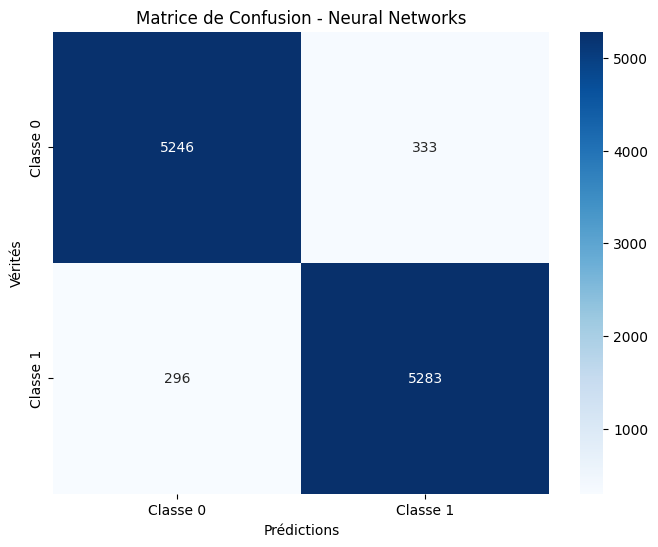

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title('Matrice de Confusion - Neural Networks')

plt.show()

# Évaluation et comparaison des modèles

Définition des **modèles** et **hyperparamètres**

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(C=10, penalty='l1', solver='saga', max_iter=1000),
    "Support Vector Machine (SVM)": SVC(kernel='rbf', gamma='scale', C=10),
    "Random Forest": RandomForestClassifier(
        n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_depth=50, random_state=42
    ),
    "XGBoost": xgb.XGBClassifier(
        subsample=1.0, reg_lambda=0, reg_alpha=0.01, n_estimators=150, min_child_weight=1,
        max_depth=6, learning_rate=0.05, gamma=0, colsample_bytree=0.6, use_label_encoder=False, eval_metric='logloss'
    ),
    "LightGBM": lgb.LGBMClassifier(
        subsample=0.7, num_leaves=100, n_estimators=300, max_depth=5, learning_rate=0.15, colsample_bytree=0.8
    ),
    "Multinomial Naive Bayes": MultinomialNB(alpha=4.275875875875876e-06),
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(weights='distance', n_neighbors=13, metric='cosine', leaf_size=10),
    "Neural Network (MLPClassifier)": MLPClassifier(
        activation='relu', alpha=2.1171920233539622e-05, hidden_layer_sizes=(100,),
        learning_rate='adaptive', solver='adam', max_iter=1000, random_state=42
    )
}

Évaluation des modèles avec **scores** et **matrices de confusion**

Training Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


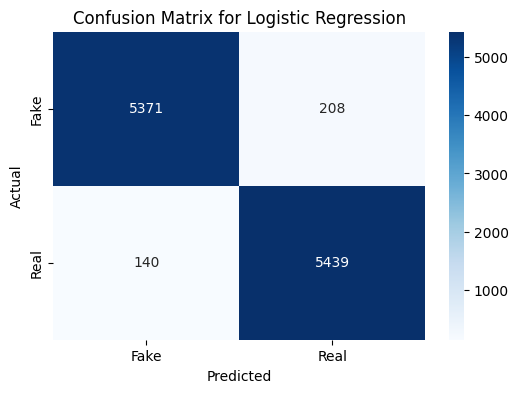

Training Support Vector Machine (SVM)...


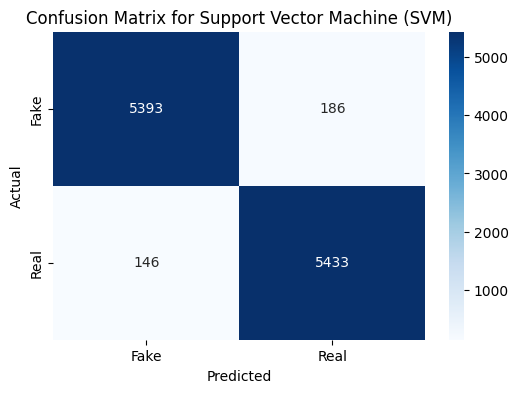

Training Random Forest...


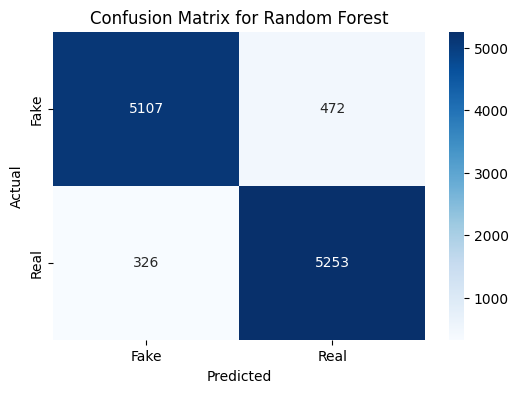

Training XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:19:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


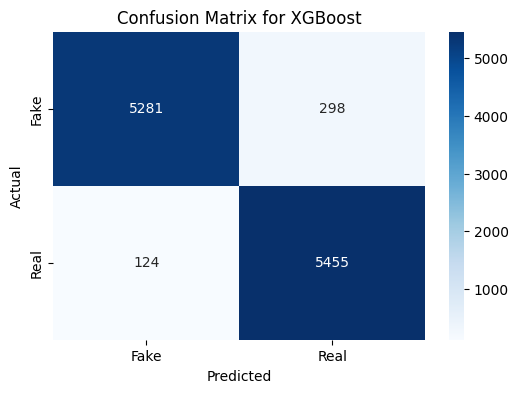

Training LightGBM...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 22316, number of negative: 22316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 10.619584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1259585
[LightGBM] [Info] Number of data points in the train set: 44632, number of used features: 21320
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


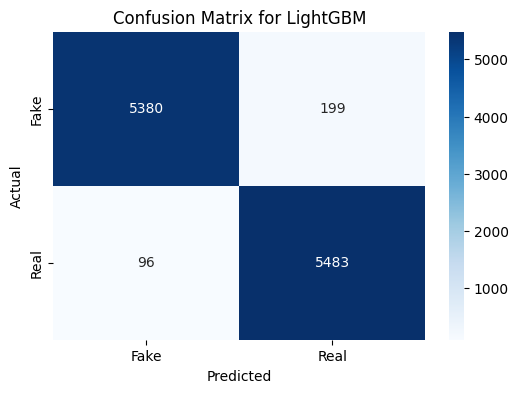

Training Multinomial Naive Bayes...


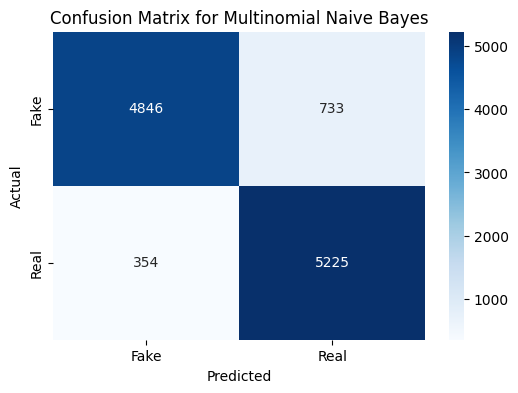

Training K-Nearest Neighbors (KNN)...


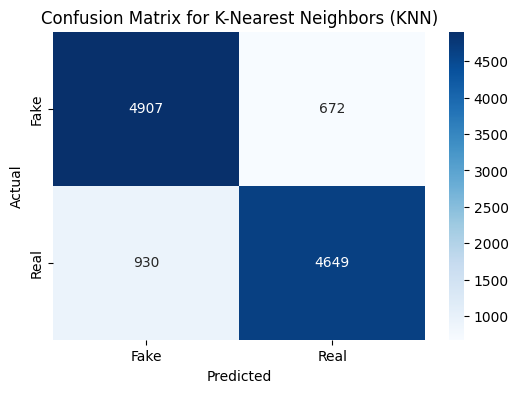

Training Neural Network (MLPClassifier)...


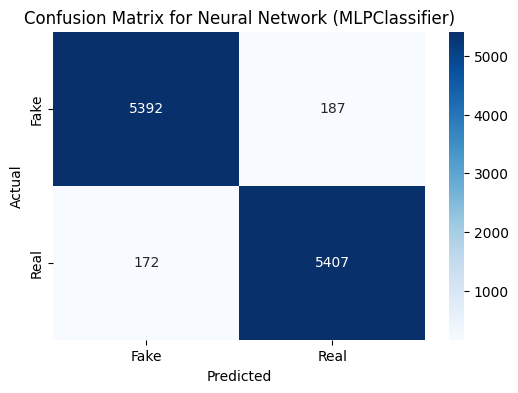

In [ ]:
results = []

for name, model in models.items():
    print(f"Training {name}...")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,

    })

    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Affichage des résultats des modèles

In [ ]:
results_df = pd.DataFrame(results)
print("\nRésultats finaux :")
print(results_df)


Résultats finaux :
                            Model  Accuracy  Precision    Recall  F1 Score
0             Logistic Regression  0.968812   0.963166  0.974906  0.969001
1    Support Vector Machine (SVM)  0.970246   0.966898  0.973830  0.970352
2                   Random Forest  0.928482   0.917555  0.941567  0.929406
3                         XGBoost  0.962180   0.948201  0.977774  0.962760
4                        LightGBM  0.973562   0.964977  0.982793  0.973803
5         Multinomial Naive Bayes  0.902581   0.876972  0.936548  0.905781
6       K-Nearest Neighbors (KNN)  0.856426   0.873708  0.833303  0.853028
7  Neural Network (MLPClassifier)  0.967826   0.966571  0.969170  0.967869


Comparaison des performances des modèles

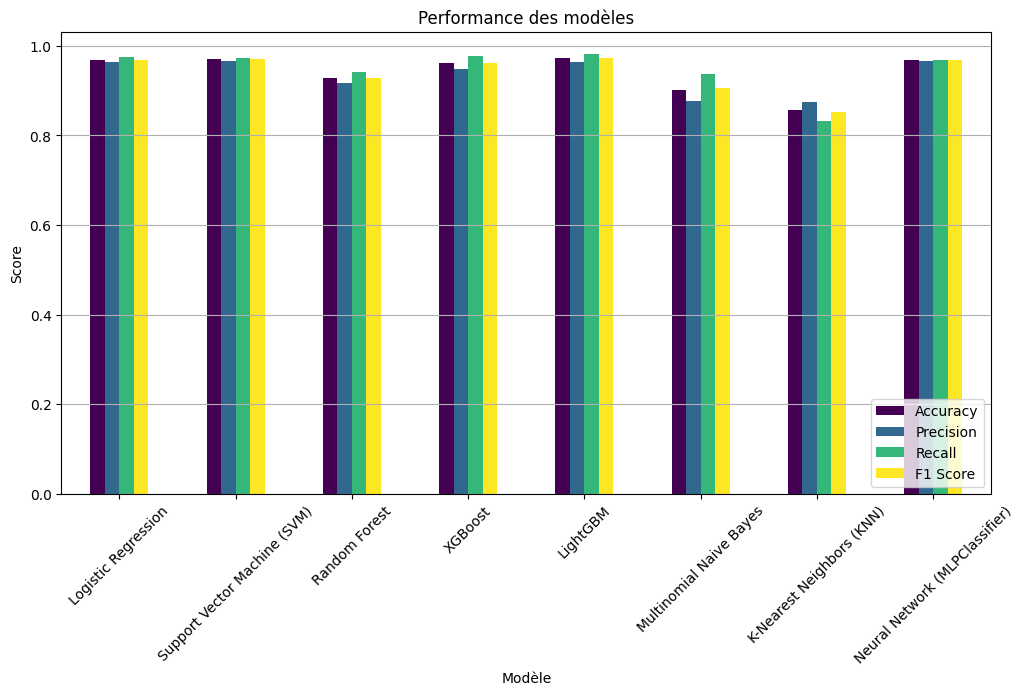

In [ ]:
results_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1 Score"]].plot(kind="bar", figsize=(12, 6), colormap="viridis")
plt.title("Performance des modèles")
plt.ylabel("Score")
plt.xlabel("Modèle")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.grid(axis='y')
plt.show()

<ipython-input-2-6bab6ddbc7d5>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results, ax=axes[0], palette="viridis")
<ipython-input-2-6bab6ddbc7d5>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Precision', data=results, ax=axes[1], palette="viridis")
<ipython-input-2-6bab6ddbc7d5>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Recall', data=results, ax=axes[2], palette="viridis")
<ipython-input-2-6bab6ddbc7d5>:26: FutureWarning: 

Passing `palette` without assigning `hue` i

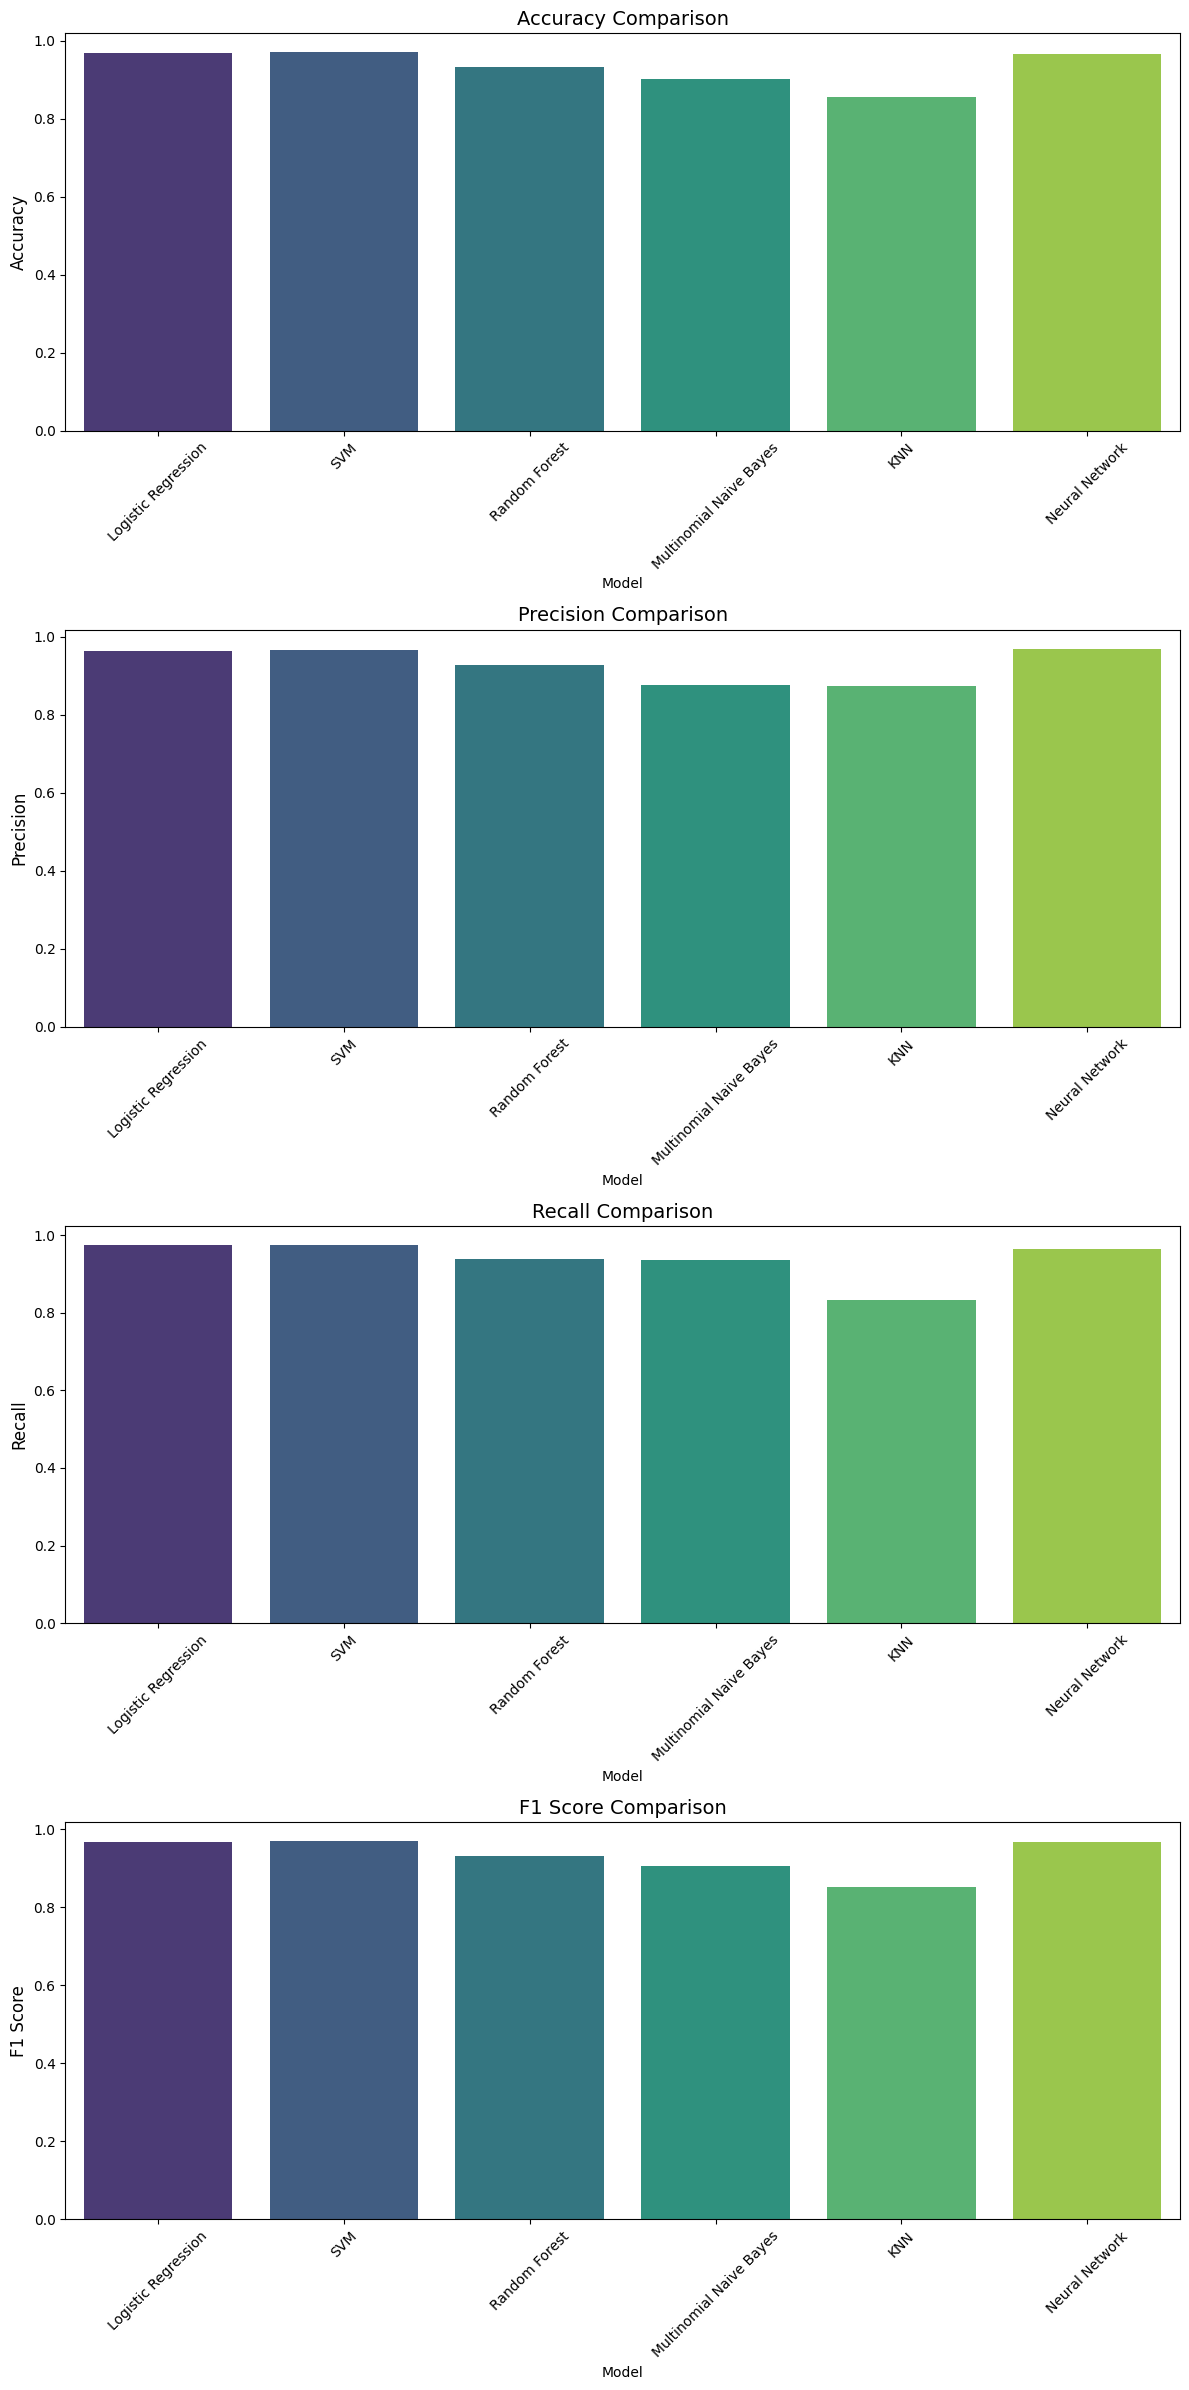

In [ ]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'Random Forest',  'Multinomial Naive Bayes', 'KNN', 'Neural Network'],
    'Accuracy': [0.968812, 0.970246, 0.932156,  0.902760, 0.856426, 0.966930],
    'Precision': [0.963166, 0.966732, 0.926726,  0.877520, 0.874412, 0.970217],
    'Recall': [0.974906, 0.974010, 0.938519,  0.936189, 0.832407, 0.963434],
    'F1 Score': [0.969001, 0.970357, 0.932585,  0.905906, 0.852893, 0.966814]
})

fig, axes = plt.subplots(4, 1, figsize=(12, 24))

sns.barplot(x='Model', y='Accuracy', data=results, ax=axes[0], palette="viridis")
axes[0].set_title('Accuracy Comparison', fontsize=14)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(x='Model', y='Precision', data=results, ax=axes[1], palette="viridis")
axes[1].set_title('Precision Comparison', fontsize=14)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

sns.barplot(x='Model', y='Recall', data=results, ax=axes[2], palette="viridis")
axes[2].set_title('Recall Comparison', fontsize=14)
axes[2].set_ylabel('Recall', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)

sns.barplot(x='Model', y='F1 Score', data=results, ax=axes[3], palette="viridis")
axes[3].set_title('F1 Score Comparison', fontsize=14)
axes[3].set_ylabel('F1 Score', fontsize=12)
axes[3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
svm_model = SVC(kernel='rbf', gamma='scale', C=10)

In [ ]:
svm_model.fit(X_train, y_train)


SVC(C=10)

In [ ]:
y_train_pred = svm_model.predict(X_train)
y_test_pred = svm_model.predict(X_test)

# Évaluer les performances sur l'ensemble d'entraînement
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Train Accuracy: {train_accuracy:.4f}")

# Évaluer les performances sur l'ensemble de test
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.9999
Test Accuracy: 0.9702


In [ ]:
# Rapport de classification
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5579
           1       0.97      0.97      0.97      5579

    accuracy                           0.97     11158
   macro avg       0.97      0.97      0.97     11158
weighted avg       0.97      0.97      0.97     11158



In [ ]:
joblib.dump(svm_model, "svm_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
print("Modèle et vectoriseur TF-IDF sauvegardés avec succès.")

NameError: name 'svm_model' is not defined

In [3]:
svm_model = joblib.load("/content/drive/MyDrive/svm_model.pkl")
tfidf = joblib.load("/content/drive/MyDrive/tfidf_vectorizer.pkl")
print("Modèle et vectoriseur TF-IDF chargés avec succès.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/svm_model.pkl'

In [ ]:
# Filtrer les articles "fake"
fake_articles = data[data['label'] == 0]

# Vérifier s'il y a des articles "fake"
if fake_articles.empty:
    print("Aucun article fake trouvé dans le dataset.")
else:
    # Sélectionner un article "fake" spécifique
    selected_article = fake_articles.iloc[0]['text']
    print("Article sélectionné :")
    print(selected_article)


Article sélectionné :
brussels reuters british prime minister theresa may s offer settled status eu residents flawed will leave them fewer rights after brexit european parliament s brexit coordinator said tuesday family five could face bill pounds acquire new status guy verhofstadt told may s brexit secretary david davis letter seen by reuters very significant amount family low income listing three other concerns eu legislature which must approve any treaty march exit verhofstadt told davis under your proposals eu citizens will definitely notice deterioration their status result brexit parliament s aim all along has been eu citizens uk citizens eu should notice no difference verhofstadt former belgian prime minister wrote response davis who had written him after parliament complained last week there remained major issues be settled rights million eu citizens britain tuesday he told reporters parliament was determined expatriates should not become victims brexit may had unveiled more de

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
print(data['label'].unique())


[1 0]


In [ ]:
print(data.columns)


Index(['title', 'text', 'label'], dtype='object')


In [ ]:
import re
import string

def nettoyer_article(text):


    # Liste de stopwords (personnalisée pour ton projet)
    stopwords = ['the', 'and', 'is', 'in', 'it', 'on', 'to', 'of', 'a', 'for', 'with', 'as', 'that']

    # 1. Supprimer les espaces supplémentaires
    text = text.strip()
    text = ' '.join(text.split())

    # 2. Supprimer les liens, mentions, hashtags, chiffres et ponctuation
    text = re.sub(r'http\S+', '', text)  # Supprimer les liens (URLs)
    text = re.sub(r'@\w+', '', text)  # Supprimer les mentions (@utilisateur)
    text = re.sub(r'#\w+', '', text)  # Supprimer les hashtags (#hashtag)
    text = re.sub(r'\d+', '', text)  # Supprimer les chiffres
    text = re.sub(r'[^\w\s]', '', text)  # Supprimer la ponctuation

    # 3. Convertir en minuscules
    text = text.lower()

    # 4. Supprimer les stopwords
    words = text.split()
    words = [word for word in words if word not in stopwords]
    text = ' '.join(words)

    # 5. Nettoyage supplémentaire des caractères non alphabétiques
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    return text



In [ ]:
article_tfidf = tfidf.transform([cleaned_article])

# Faire une prédiction avec le modèle SVM
prediction = svm_model.predict(article_tfidf)

# Afficher la prédiction
if prediction[0] == 0:
    print("Cet article est FAUX (Fake News).")
else:
    print("Cet article est VRAI.")

Cet article est FAUX (Fake News).


In [ ]:
import pandas as pd

# Charger le dataset
test_data = pd.read_csv('/content/drive/MyDrive/test_dataset.csv')

# Vérifier les premières lignes
print(test_data.head())

# Filtrer les articles Fake et Real
fake_articles = test_data[test_data['label'] == 'FAKE']
real_articles = test_data[test_data['label'] == 'REAL']

# Sélectionner 2 articles Fake et 2 articles Real
sample_fake = fake_articles.sample(n=2, random_state=42)  # Pour des résultats reproductibles
sample_real = real_articles.sample(n=2, random_state=42)

# Combiner les échantillons dans un seul dataset
sample_data = pd.concat([sample_fake, sample_real]).reset_index(drop=True)

# Combiner le titre et le texte
sample_data['combined'] = sample_data['title'] + " " + sample_data['text']

# Appliquer la méthode de nettoyage sur les articles combinés
sample_data['cleaned_combined'] = sample_data['combined'].apply(nettoyer_article)

# Prédire pour chaque article
for i, row in sample_data.iterrows():
    article_text = row['cleaned_combined']
    true_label = row['label']

    # Convertir le texte en représentation TF-IDF
    vectorized_text = tfidf.transform([article_text])

    # Faire la prédiction
    predicted_label = svm_model.predict(vectorized_text)[0]

    # Afficher les résultats
    print(f"Article {i+1} :")
    print(f"- Texte combiné : {row['combined'][:100]}...")  # Afficher les 100 premiers caractères
    print(f"- Label réel : {true_label}")
    print(f"- Prédiction : {'REAL' if predicted_label == 1 else 'FAKE'}")
    print()


                                               title  \
0  Bobby Jindal, raised Hindu, uses story of Chri...   
1  May Brexit offer would hurt, cost EU citizens ...   
2  Schumer calls on Trump to appoint official to ...   
3  No Change Expected for ESPN Political Agenda D...   
4  Billionaire Odebrecht in Brazil scandal releas...   

                                                text label  
0  A dozen politically active pastors came here f...  FAKE  
1  BRUSSELS (Reuters) - British Prime Minister Th...  FAKE  
2  WASHINGTON (Reuters) - Charles Schumer, the to...  FAKE  
3  As more and more sports fans turn off ESPN to ...  FAKE  
4  RIO DE JANEIRO/SAO PAULO (Reuters) - Billionai...  FAKE  
Article 1 :
- Texte combiné : Two People Die after Eating Raw-Milk Cheese Made in New York State - The New York Times Two people h...
- Label réel : FAKE
- Prédiction : FAKE

Article 2 :
- Texte combiné : DUP blames Sinn Fein for Northern Ireland talks collapse BELFAST (Reuters) - A senior member

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/test_dataset.csv')

# Filtrer les articles Fake et Real
fake_articles = test_data[test_data['label'] == 'FAKE']
real_articles = test_data[test_data['label'] == 'REAL']

# Sélectionner 2 articles Fake et 2 articles Real
sample_fake = fake_articles.sample(n=2, random_state=42)  # Pour avoir des résultats reproductibles
sample_real = real_articles.sample(n=2, random_state=42)

# Combiner les échantillons dans un seul dataset
sample_data = pd.concat([sample_fake, sample_real]).reset_index(drop=True)

In [ ]:
import textwrap

# Afficher les articles avec leur label (FAKE ou REAL)
print("Voici les articles disponibles :\n")
for i, row in sample_data.iterrows():
    print(f"Article {i+1}:")
    print(f"  Titre: {row['title']}")
    print(f"  Label: {row['label']}")  # Afficher si l'article est FAKE ou REAL

    # Formater le texte pour qu'il s'affiche sur plusieurs lignes
    formatted_text = "\n".join(textwrap.wrap(row['text'], width=80))
    print(f"  Texte:\n{formatted_text}")
    print()


Voici les articles disponibles :

Article 1:
  Titre: Two People Die after Eating Raw-Milk Cheese Made in New York State - The New York Times
  Label: FAKE
  Texte:
Two people have died following an outbreak of listeria linked to a popular
artisanal raw milk cheese made in upstate New York, the authorities said this
week. The deaths occurred in Vermont and Connecticut, local officials said. Four
other people in New York and Florida reported feeling sick after eating Ouleout,
the artisanal cheese, which is produced by Vulto Creamery in Walton. Illnesses
started on dates from Sept. 1 of last year to Jan. 22, the Food and Drug
Administration said. All six people were hospitalized and two people died.
Ouleout has been celebrated across the United States as much for its unusual
back story as for its flavor: It was created by Jos Vulto, a Dutch artist linked
to the Museum of Modern Art, who started making cheese in his apartment and
aging it under a sidewalk in Brooklyn. Vulto Creamery, whic

In [ ]:
def predire_article():
    # Afficher des champs pour saisir le titre et le texte
    print("Veuillez entrer le titre de l'article :")
    user_title = input()  # Saisie du titre

    print("Veuillez entrer le texte de l'article :")
    user_text = input()  # Saisie du texte

    # Appliquer le nettoyage sur le texte
    cleaned_text = nettoyer_article(user_text)

    # Vectoriser le texte nettoyé
    vectorized_text = tfidf.transform([cleaned_text])

    # Prédiction avec le modèle SVM
    predicted_label = svm_model.predict(vectorized_text)[0]

    # Afficher les résultats
    print("\nRésultat de la prédiction :")
    print(f"Le titre de l'article: {user_title}")
    print(f"Le texte de l'article: {user_text}")  # Afficher le texte complet
    print(f"Prédiction : {'REAL' if predicted_label == 1 else 'FAKE'}")


In [ ]:
predire_article()


Veuillez entrer le titre de l'article :
Two People Die after Eating Raw-Milk Cheese Made in New York State - The New York Times
Veuillez entrer le texte de l'article :
Two people have died following an outbreak of listeria linked to a popular artisanal raw milk cheese made in upstate New York, the authorities said this week. The deaths occurred in Vermont and Connecticut, local officials said. Four other people in New York and Florida reported feeling sick after eating Ouleout, the artisanal cheese, which is produced by Vulto Creamery in Walton. Illnesses started on dates from Sept. 1 of last year to Jan. 22, the Food and Drug Administration said. All six people were hospitalized and two people died. Ouleout has been celebrated across the United States as much for its unusual back story as for its flavor: It was created by Jos Vulto, a Dutch artist linked to the Museum of Modern Art, who started making cheese in his apartment and aging it under a sidewalk in Brooklyn. Vulto Creamery, w